In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# COMPLETE PAPER PIPELINE **YOLOV5 + PDLPR**



#YOLOV5 INFERENCE

In [ ]:
!cp -r /content/drive/MyDrive/ccpd_green /content/

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 17516 (delta 6), reused 0 (delta 0), pack-reused 17497 (from 4)
Receiving objects: 100% (17516/17516), 16.62 MiB | 30.29 MiB/s, done.
Resolving deltas: 100% (12001/12001), done.


In [ ]:
!pip install -r /content/yolov5/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 881.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/train" --data inference_data.yaml --save-txt --save-crop

Output streaming troncato alle ultime 5000 righe.
image 3247/8243 /content/ccpd_green/train/0303645833333-89_266-188&406_506&502-496&491_188&502_191&413_506&406-0_0_3_25_30_30_32_32-88-124.jpg: 640x416 1 license_plate, 8.1ms
image 3248/8243 /content/ccpd_green/train/0303645833333-90_254-189&464_507&560-507&560_210&546_189&464_492&468-0_0_3_24_31_27_31_28-110-309.jpg: 640x416 1 license_plate, 9.5ms
image 3249/8243 /content/ccpd_green/train/0303645833333-90_268-194&454_512&550-510&548_196&550_194&456_512&454-0_0_3_24_24_27_30_24-113-273.jpg: 640x416 1 license_plate, 8.2ms
image 3250/8243 /content/ccpd_green/train/03037109375-89_265-220&409_531&507-531&499_228&507_220&419_531&409-0_0_3_24_24_25_29_28-87-90.jpg: 640x416 1 license_plate, 8.1ms
image 3251/8243 /content/ccpd_green/train/0304090711806-92_251-184&406_479&509-479&509_207&489_184&406_458&418-0_0_3_24_33_33_33_25-57-34.jpg: 640x416 1 license_plate, 8.1ms
image 3252/8243 /content/ccpd_green/train/03041232638888889-90_268-185&454_49

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/val" --data inference_data.yaml --save-txt --save-crop

detect: weights=['yolo_finetuned_model.pt'], source=/content/ccpd_green/val, data=inference_data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1766 /content/ccpd_green/val/0021264367816091955-90_267-311&542_385&569-385&567_312&569_311&542_382&543-0_0_3_30_31_32_32_31-120-9.jpg: 640x416 1 license_plate, 27.7ms
image 2/1766 /content/ccpd_green/val/003400383141762452-89_263-280&509_351&553-351&539_285&553_280&512_343&509-0_0_3_29_27_33_32_32-11

In [ ]:
!python yolov5/detect.py --weights yolo_finetuned_model.pt --source "/content/ccpd_green/test" --data inference_data.yaml --save-txt --save-crop

detect: weights=['yolo_finetuned_model.pt'], source=/content/ccpd_green/test, data=inference_data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-422-g2540fd4c Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1767 /content/ccpd_green/test/0016594827586206896-90_90-341&550_407&573-407&573_341&571_341&550_407&550-0_0_3_27_26_32_25_32-63-3.jpg: 640x416 1 license_plate, 52.0ms
image 2/1767 /content/ccpd_green/test/0026484674329501916-93_90-283&513_362&543-360&543_283&539_283&513_362&518-0_0_3_25_32_32_33_33-9

# PDLPR

# imports

In [ ]:
import os
#import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.optim as optim
import re
import matplotlib.pyplot as plt
import time
import warnings

# global

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 256)), # Aspect ratio più realistico per targhe
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#saving fields of the licence plate as global variables, i'm gonna use them later on
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

# dict
seen = set()    #avoid duplicates
MY_DICTIONARY = []
for char_list in [provinces, alphabets, ads]:
    for char in char_list:
        if char not in seen:
            MY_DICTIONARY.append(char)
            seen.add(char)

print(f"dictionary has {len(MY_DICTIONARY)} unique chars: {MY_DICTIONARY}")

# Create character to index and index to character mappings
char2idx = {c: i for i, c in enumerate(MY_DICTIONARY)}
idx2char = {i: c for i, c in enumerate(MY_DICTIONARY)}
BLANK_IDX = len(MY_DICTIONARY)  # CTC needs +1 for "blank" , so keep the len

print(f"so i got (+1 for blank): {BLANK_IDX + 1} classes")

dictionary has 68 unique chars: ['皖', '沪', '津', '渝', '冀', '晋', '蒙', '辽', '吉', '黑', '苏', '浙', '京', '闽', '赣', '鲁', '豫', '鄂', '湘', '粤', '桂', '琼', '川', '贵', '云', '藏', '陕', '甘', '青', '宁', '新', '警', '学', 'O', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
so i got (+1 for blank): 69 classes


In [ ]:
# sanity check of dictionary, it is really important dictionary is ok for the parsing
def validate_dictionary():
    print("=== validating dict ===")
    print(f"Provinces: {len(provinces)} chars")
    print(f"Alphabets: {len(alphabets)} chars")
    print(f"Ads: {len(ads)} chars")
    print(f"Final dict: {len(MY_DICTIONARY)} unique chars")

    # Verifica che tutti i caratteri siano mappabili
    all_chars = set(provinces + alphabets + ads)
    dict_chars = set(MY_DICTIONARY)

    if all_chars == dict_chars:
        print("all chars are included in the dict")
    else:
        missing = all_chars - dict_chars
        extra = dict_chars - all_chars
        if missing:
            print(f"missing chars: {missing}")
        if extra:
            print(f"there's extra chars!: {extra}")

    # example file
    test_filename = "025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg"
    print(f"\n=== Test Parsing ===")
    print(f"Test filename: {test_filename}")

    # parsing plate (method from the class)
    fields = test_filename.split('-')
    indices = fields[4].split("_")
    test_plate = provinces[int(indices[0])] + alphabets[int(indices[1])] + "".join([ads[int(i)] for i in indices[2:]])
    print(f"parsed plate: '{test_plate}'")

    # Verify i have all the chars in the dict
    missing_chars = [c for c in test_plate if c not in char2idx]
    if missing_chars:
        print(f"missing chars in dict: {missing_chars}")
    else:
        print("the dictionary is ok!")

validate_dictionary()

=== validating dict ===
Provinces: 34 chars
Alphabets: 25 chars
Ads: 35 chars
Final dict: 68 unique chars
all chars are included in the dict

=== Test Parsing ===
Test filename: 025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg
parsed plate: '皖AY339S'
the dictionary is ok!


# model architecture and utils

## model architecture

In [ ]:
# PDLPR MODEL FOLLOWING PAPER ARCHITECTURE

# --- Focus Structure Module ---
class Focus(nn.Module):
    def __init__(self, in_channels=1, out_channels=64, dropout=0.1):  # Fixed __init__
        super(Focus, self).__init__()  # Fixed __init__
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Slice and concat - Focus structure downsampling
        patch1 = x[..., ::2, ::2]
        patch2 = x[..., ::2, 1::2]
        patch3 = x[..., 1::2, ::2]
        patch4 = x[..., 1::2, 1::2]
        x = torch.cat([patch1, patch2, patch3, patch4], dim=1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x


# --- CNN Block used in RESBLOCK and downsampling ---
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )


# --- Residual Block ---
class ResBlock(nn.Module):
    def __init__(self, channels):  # Fixed __init__
        super(ResBlock, self).__init__()  # Fixed __init__
        self.block = nn.Sequential(
            conv_block(channels, channels),
            conv_block(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)


# --- IGFE Module ---
class IGFE(nn.Module):
    def __init__(self, dropout=0.1):  # Fixed __init__
        super(IGFE, self).__init__()  # Fixed __init__
        self.focus = Focus(1, 64, dropout)  # Changed to 1 channel for grayscale
        self.down1 = conv_block(64, 128, stride=2)
        self.res1 = ResBlock(128)
        self.res2 = ResBlock(128)
        self.down2 = conv_block(128, 256, stride=2)
        self.res3 = ResBlock(256)
        self.res4 = ResBlock(256)
        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 18))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.focus(x)
        x = self.down1(x)
        x = self.dropout(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down2(x)
        x = self.dropout(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.final_conv(x)
        x = self.adaptive_pool(x)
        return x


# --- Positional Encoding for 2D feature maps ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, height, width):  # Fixed __init__
        super().__init__()  # Fixed __init__
        self.pe = nn.Parameter(torch.randn(1, d_model, height, width))

    def forward(self, x):
        return x + self.pe


# --- Transformer Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, d_model):  # Fixed __init__
        super(EncoderBlock, self).__init__()  # Fixed __init__
        self.self_attn = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # [B, HW, C]

        # Self-attention
        attn_out, _ = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_out))

        # FFN
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))

        return x.transpose(1, 2).view(B, C, H, W)


# --- PDLPR Recognition Model (CTC-based) ---
class PDLPR(nn.Module):
    def __init__(self, num_classes, dropout=0.1):  # Fixed __init__
        super(PDLPR, self).__init__()  # Fixed __init__
        self.igfe = IGFE(dropout)
        self.pos_encoding = PositionalEncoding(512, 6, 18)
        self.encoder = nn.Sequential(*[EncoderBlock(512) for _ in range(3)])

        # CTC head - outputs sequence of characters
        # After flattening, we have [B, W, C*H] = [B, 18, 512*6] = [B, 18, 3072]
        self.ctc_head = nn.Sequential(
            nn.Linear(512 * 6, 256),  # Fixed dimension: 512*6 = 3072
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Feature extraction
        x = self.igfe(x)  # [B, 512, 6, 18]
        x = self.pos_encoding(x)
        x = self.encoder(x)  # [B, 512, 6, 18]

        # Flatten to sequence for CTC
        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2)  # [B, W, C, H]
        x = x.contiguous().view(B, W, -1)  # [B, W, C*H] = [B, 18, 3072]

        # Linear projection to reduce dimension
        x = self.ctc_head(x)  # [B, W, num_classes]
        x = x.permute(1, 0, 2)  # [W, B, num_classes] for CTC

        return x

## utils

In [ ]:
def ctc_collate_fn(batch):
    '''
    basically what I do here is stacking all the images in a batch into a single tensor and
    then computing the len of each label (assuming different lenght plate can happen). (I could actually avoid this but it's more general)
    Finally just concatenating all the labels into a vector (pytorch CTC wantres them in a line, not list)
    then returning image-label-its lenght.
    I need this to tell CTC where labels finish and i do not care padding as CTC deals with that internally (NICE)
    '''
    images, labels = zip(*batch)
    images = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat(labels)
    return images, labels, label_lengths


'''def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels, label_lengths in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # [W, B, num_classes]
        log_probs = outputs.log_softmax(2)
        input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long).to(device)
        loss = criterion(log_probs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch average loss: {avg_loss:.4f}")
    return avg_loss'''



def get_plate(filename):
    fields = filename.split('-')

    text=str(fields[4])
    indices=text.split("_")
    province_character=provinces[int(indices[0])]
    alphabet_character=alphabets[int(indices[1])]
    ads_charachters=[ads[int(i)] for i in indices[2:]]
    plate_text=province_character+alphabet_character+"".join(ads_charachters)

    return plate_text



def ctc_greedy_decoder(output, idx2char, blank=BLANK_IDX):
    '''
    Now, I know the network returns probabilities, as it does a softmax with logits of characters.
    I need to transform that probability into an actual char to compose the plate.
    I take the argmax of the softmax (most prob char), remove blanks used by CTC and possible
    duplicates CTC can actually produce.
    At the end I simply use the  mappings char-index index-char deefined at the beginning to compose the plate.
    This is greedy as it just takes the argmax of every step, I think it's more than enough here.
    '''
    # output: [seq_len, batch, num_classes]
    out = output.permute(1, 0, 2)  # [batch, seq_len, num_classes]
    pred_strings = []
    for probs in out:
        pred = probs.argmax(1).cpu().numpy()
        prev = -1
        pred_str = []
        for p in pred:
            if p != blank and p != prev:
                pred_str.append(idx2char[p])
            prev = p
        pred_strings.append(''.join(pred_str))
    return pred_strings


'''def evaluate(model, dataloader, device, verbose=False):
    model.eval()
    total = 0
    correct = 0
    total_chars = 0
    correct_chars = 0

    # Metriche aggiuntive per analisi dettagliata
    length_errors = 0
    province_correct = 0
    alphabet_correct = 0

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)
            labels_cpu = labels.cpu().numpy()   #need to move tensors tu cpu memory for numpy
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            for pred, gt in zip(pred_strings, gt_strings):
                # Accuracy completa
                if pred == gt:
                    correct += 1
                total += 1

                # Accuracy per carattere
                min_len = min(len(pred), len(gt))
                correct_chars += sum([p == g for p, g in zip(pred[:min_len], gt[:min_len])])
                total_chars += len(gt)

                # Metriche aggiuntive
                if len(pred) != len(gt):
                    length_errors += 1

                # Accuracy per provincia (primo carattere)
                if len(pred) > 0 and len(gt) > 0 and pred[0] == gt[0]:
                    province_correct += 1

                # Accuracy per alfabeto (secondo carattere)
                if len(pred) > 1 and len(gt) > 1 and pred[1] == gt[1]:
                    alphabet_correct += 1

                # Stampa esempi di errore se richiesto
                if verbose and pred != gt and batch_idx == 0:
                    print(f"Pred: '{pred}' | GT: '{gt}'")

    acc = correct / total if total > 0 else 0
    acc_char = correct_chars / total_chars if total_chars > 0 else 0
    length_error_rate = length_errors / total if total > 0 else 0
    province_acc = province_correct / total if total > 0 else 0
    alphabet_acc = alphabet_correct / total if total > 0 else 0

    print(f"Eval accuracy (full plate): {acc:.4f} | Char accuracy: {acc_char:.4f}")
    print(f"Length error rate: {length_error_rate:.4f} | Province acc: {province_acc:.4f} | Alphabet acc: {alphabet_acc:.4f}")

    return acc, acc_char'''


def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch):
    model.train()
    total_loss = 0
    start_time = time.time()

    for batch_idx, (images, labels, label_lengths) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        label_lengths = label_lengths.to(device)

        optimizer.zero_grad()
        outputs = model(images)  # [W, B, num_classes]
        log_probs = outputs.log_softmax(2)
        input_lengths = torch.full(size=(images.size(0),), fill_value=log_probs.size(0), dtype=torch.long).to(device)

        loss = criterion(log_probs, labels, input_lengths, label_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Log batch loss every 100 batches
        if batch_idx % 100 == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "epoch": epoch,
                "batch": batch_idx
            })

    avg_loss = total_loss / len(dataloader)
    epoch_time = time.time() - start_time

    # Log epoch metrics
    wandb.log({
        "train_loss": avg_loss,
        "epoch_time": epoch_time,
        "epoch": epoch,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    print(f"Epoch {epoch} - Train Loss: {avg_loss:.4f} - Time: {epoch_time:.2f}s")
    return avg_loss


def evaluate(model, dataloader, device, epoch=None, verbose = False,):
    model.eval()
    total = 0
    correct = 0
    total_chars = 0
    correct_chars = 0
    start_time = time.time()

    # Metriche aggiuntive
    length_errors = 0
    province_correct = 0
    alphabet_correct = 0

    with torch.no_grad():
        for images, labels, label_lengths in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)

            # Get ground truth
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            # Calculate metrics
            for pred, gt in zip(pred_strings, gt_strings):
                if pred == gt:
                    correct += 1
                total += 1

                # Character-level accuracy
                min_len = min(len(pred), len(gt))
                correct_chars += sum([p == g for p, g in zip(pred[:min_len], gt[:min_len])])
                total_chars += len(gt)

                # Metriche aggiuntive
                if len(pred) != len(gt):
                    length_errors += 1

                # Accuracy per provincia (primo carattere)
                if len(pred) > 0 and len(gt) > 0 and pred[0] == gt[0]:
                    province_correct += 1

                # Accuracy per alfabeto (secondo carattere)
                if len(pred) > 1 and len(gt) > 1 and pred[1] == gt[1]:
                    alphabet_correct += 1


    # Calculate final metrics
    acc = correct / total if total > 0 else 0
    char_acc = correct_chars / total_chars if total_chars > 0 else 0
    eval_time = time.time() - start_time
    length_error_rate = length_errors / total if total > 0 else 0
    province_acc = province_correct / total if total > 0 else 0
    alphabet_acc = alphabet_correct / total if total > 0 else 0

    # Log validation metrics
    if epoch is not None:
        wandb.log({
            "val_accuracy": acc,
            "val_char_accuracy": char_acc,
            "val_time": eval_time,
            "epoch": epoch
        })

    print(f"Val Accuracy: {acc:.4f} - Char Accuracy: {char_acc:.4f} - Time: {eval_time:.2f}s")
    print(f"Length error rate: {length_error_rate:.4f} | Province acc: {province_acc:.4f} | Alphabet acc: {alphabet_acc:.4f}")
    return acc, char_acc

# data

In [ ]:
class CarPlateDataset(Dataset):

    def __init__(self, img_dir, transform=None, cropped = False):
        self.img_dir = img_dir
        self.transform = transform
        self.image_names = os.listdir(img_dir)
        self.cropped = cropped


    def __len__(self):
        return len(self.image_names)

    def parse_filename(self, filename):
        fields = filename.split('-')
        area = float(fields[0]) / 100  #filename encodes the area in percentage (ratio plate-no plate area), so divising by 100 gives me a 0-1 range
        tilt_degree = fields[1].split('_')
        h_tilt = int(tilt_degree[0])    #horizontal tilt degree
        v_tilt = int(tilt_degree[1])    #vertical tilt degree
        tilt_list = np.array([h_tilt, v_tilt], dtype=np.float32)


        bbox_coords = fields[2].split('_')  #bounding box coordinates
        leftUp_bbox = bbox_coords[0].split('&')
        leftUp_bbox_x = int(leftUp_bbox[0])
        leftUp_bbox_y = int(leftUp_bbox[1])
        rightBottom_bbox = bbox_coords[1].split('&')
        rightDown_bbox_x = int(rightBottom_bbox[0])
        rightDown_bbox_y = int(rightBottom_bbox[1])
        bbox_coords_list = np.array([(leftUp_bbox_x, leftUp_bbox_y),
                                    (rightDown_bbox_x, rightDown_bbox_y)], dtype=np.float32)

        vertices = fields[3].split('_')  #vertices of the plate
        right_bottom_vertex = vertices[0].split('&')
        right_bottom_vertex_x = int(right_bottom_vertex[0])
        right_bottom_vertex_y = int(right_bottom_vertex[1])
        left_bottom_vertex = vertices[1].split('&')
        left_bottom_vertex_x = int(left_bottom_vertex[0])
        left_bottom_vertex_y = int(left_bottom_vertex[1])
        left_up_vertex = vertices[2].split('&')
        left_up_vertex_x = int(left_up_vertex[0])
        left_up_vertex_y = int(left_up_vertex[1])
        right_up_vertex = vertices[3].split('&')
        right_up_vertex_x = int(right_up_vertex[0])
        right_up_vertex_y = int(right_up_vertex[1])

        vertices_list = np.array([(left_bottom_vertex_x, left_bottom_vertex_y),
                                (right_bottom_vertex_x, right_bottom_vertex_y),
                                (right_up_vertex_x, right_up_vertex_y),
                                (left_up_vertex_x, left_up_vertex_y)], dtype=np.float32)

        # Usa le variabili globali invece di ridefinirle
        text=str(fields[4])
        indices=text.split("_")
        province_character=provinces[int(indices[0])]
        alphabet_character=alphabets[int(indices[1])]
        ads_charachters=[ads[int(i)] for i in indices[2:]]
        plate_text=province_character+alphabet_character+"".join(ads_charachters)

        brightness = int(fields[5])
        #blurriness = int(fields[6].strip('.jpg'))  # Remove .jpg, it's end of filename
        #it gave problems, try with this
        blurriness_str = fields[6].replace('.jpg', '')
        match = re.match(r'\d+', blurriness_str)
        if match:
            blurriness = int(match.group())
        else:
            print(f"[WARNING] File '{filename}': blurriness non standard '{fields[6]}', imposto a 0.")
            blurriness = 0

        # Convert license plate text to indices for CTC training
        # Aggiungi controllo per caratteri non riconosciuti
        lp_indexes = []
        for c in plate_text:
            if c in char2idx:
                lp_indexes.append(char2idx[c])
            else:
                print(f"[WARNING] Carattere non riconosciuto '{c}' in '{plate_text}'")

        return {
            'area': area,
            'tilt': tilt_list,
            'bbox_coords': bbox_coords_list,
            'vertices': vertices_list,
            'lp': plate_text,
            'lp_indexes': lp_indexes,
            'brightness': brightness,
            'blurriness': blurriness,
        }

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Load the image
        image = Image.open(img_path)

        # Parse the filename to get the associated metadata
        metadata = self.parse_filename(img_name)

        if self.cropped:    #I use this dataset for both baselines, so I check if I need to skip detection part and use dataset bbox.
            #I can use the crop method of PIL, that crops the image using coords in this way: (left, upper, right, lower)
            '''
            left is the x-coordinate of the left edge.

            upper is the y-coordinate of the top edge.

            right is the x-coordinate of the right edge.

            lower is the y-coordinate of the bottom edge.
            seen on the online odcs of pillow
            '''
            bbox_coords = metadata['bbox_coords']

            left = int(bbox_coords[0][0])   # x-coordinate of the left edge
            upper = int(bbox_coords[0][1])  # y-coordinate of the top edge
            right = int(bbox_coords[1][0])  # x-coordinate of the right edge
            lower = int(bbox_coords[1][1])  # y-coordinate of the bottom edge

            image = image.crop((left, upper, right, lower))

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(metadata['lp_indexes'], dtype=torch.long)  # Return the image and the license plate indexes as a tensor, for the CNN to elaborate

In [ ]:

# Create datasets
train_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_train/crops/license_plate',
    transform=transform,
    cropped=False
)

val_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_val/crops/license_plate',
    transform=transform,
    cropped=False
)

test_dataset = CarPlateDataset(
    img_dir='/content/yolov5/runs/detect/yolo_test/crops/license_plate',
    transform=transform,
    cropped=False
)


# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=ctc_collate_fn,
    num_workers = 0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 8341
Validation samples: 1790
Test samples: 1789


# network

In [ ]:
wandb.init(
    project="pdlpr-license-plate-recognition",
    config={
        "architecture": "PDLPR",
        "dataset": "CCPD_green",
        "batch_size": 32,
        "learning_rate": 0.001,
        "epochs": 50,
        "optimizer": "Adam",
        "image_size": (64, 256),
        "num_classes": 69,
        "dropout": 0.1
    }
)


# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create model
model = PDLPR(num_classes=BLANK_IDX + 1, dropout=0.1).to(device)

# Print model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

# Loss function and optimizer
criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("Model initialized successfully!")

Using device: cuda
Model has 13,774,469 trainable parameters
Model initialized successfully!


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# train

## complete train

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gzara (gzara-sapienza-universit-di-roma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Training loop
num_epochs = 15
best_val_acc = 0.0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")

    # Training
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    train_losses.append(train_loss)

    # Validation
    val_acc, val_char_acc = evaluate(model, val_loader, device, epoch, verbose=(epoch % 10 == 0))
    val_accuracies.append(val_acc)

    # Learning rate scheduler
    scheduler.step(train_loss)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_char_acc': val_char_acc,
            'train_loss': train_loss,
        }, 'best_pdlpr_model.pth')

        # Log best model info to wandb
        wandb.log({
            "best_val_acc": best_val_acc,
            "best_epoch": epoch
        })

        print(f"New best model saved! Validation accuracy: {val_acc:.4f}")

     # Log summary metrics
    wandb.log({
        "epoch": epoch,
        "best_val_acc_so_far": best_val_acc
        })

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")


wandb.summary["final_best_val_acc"] = best_val_acc
wandb.summary["total_epochs"] = num_epochs

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.4f}")

wandb.finish()



--- Epoch 1/15 ---
Epoch 0 - Train Loss: 1.4395 - Time: 46.60s
Val Accuracy: 0.3223 - Char Accuracy: 0.8336 - Time: 4.59s
Length error rate: 0.0089 | Province acc: 0.9670 | Alphabet acc: 0.9771
New best model saved! Validation accuracy: 0.3223
Current LR: 0.001000

--- Epoch 2/15 ---
Epoch 1 - Train Loss: 0.2556 - Time: 45.27s
Val Accuracy: 0.7709 - Char Accuracy: 0.9440 - Time: 5.63s
Length error rate: 0.0028 | Province acc: 0.9709 | Alphabet acc: 0.9827
New best model saved! Validation accuracy: 0.7709
Current LR: 0.001000

--- Epoch 3/15 ---
Epoch 2 - Train Loss: 0.1604 - Time: 45.74s
Val Accuracy: 0.8117 - Char Accuracy: 0.9523 - Time: 5.12s
Length error rate: 0.0000 | Province acc: 0.9804 | Alphabet acc: 0.9832
New best model saved! Validation accuracy: 0.8117
Current LR: 0.001000

--- Epoch 4/15 ---
Epoch 3 - Train Loss: 0.1184 - Time: 46.29s
Val Accuracy: 0.8659 - Char Accuracy: 0.9647 - Time: 4.62s
Length error rate: 0.0000 | Province acc: 0.9804 | Alphabet acc: 0.9832
New bes

batch,▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁▅▁▅█▁▅█▁█
batch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,▁▁▂▃▃▅▅▇█
best_val_acc,▁▆▇▇█████
best_val_acc_so_far,▁▆▇▇███████████
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
epoch_time,█▁▃▆▇▇▆█▅▅▇▅▅▅▆
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇███▇███████
val_char_accuracy,▁▆▇▇███▇███████


# test

In [ ]:


# Load best model
if os.path.exists('best_pdlpr_model.pth'):
    checkpoint = torch.load('best_pdlpr_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with validation accuracy: {checkpoint['val_acc']:.4f}")
else:
    print("No saved model found, using current model")

# Test the model
print("\n=== Final Test Results ===")
test_acc, test_char_acc = evaluate(model, test_loader, device, verbose=True)

print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Character Accuracy: {test_char_acc:.4f}")

# Test on a few sample images
def test_sample_predictions(model, test_loader, num_samples=5):
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(test_loader):
            if samples_shown >= num_samples:
                break

            images = images.to(device)
            outputs = model(images)
            pred_strings = ctc_greedy_decoder(outputs, idx2char)

            # Get ground truth
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = label_lengths.cpu().numpy()
            idx = 0
            gt_strings = []
            for l in lengths_cpu:
                gt = ''.join([idx2char[i] for i in labels_cpu[idx:idx+l]])
                gt_strings.append(gt)
                idx += l

            # Show predictions
            for i, (pred, gt) in enumerate(zip(pred_strings, gt_strings)):
                if samples_shown >= num_samples:
                    break
                print(f"Sample {samples_shown+1}: Predicted: '{pred}' | Ground Truth: '{gt}' | Match: {pred == gt}")
                samples_shown += 1

            if samples_shown >= num_samples:
                break

print("\n=== Sample Predictions ===")
test_sample_predictions(model, test_loader, num_samples=10)

Loaded best model from epoch 14 with validation accuracy: 0.9196

=== Final Test Results ===
Val Accuracy: 0.9184 - Char Accuracy: 0.9778 - Time: 4.74s
Length error rate: 0.0006 | Province acc: 0.9911 | Alphabet acc: 0.9916

Final Test Accuracy: 0.9184
Final Test Character Accuracy: 0.9778

=== Sample Predictions ===
Sample 1: Predicted: '皖AD03128' | Ground Truth: '皖AD03128' | Match: True
Sample 2: Predicted: '皖AF11777' | Ground Truth: '皖AF11777' | Match: True
Sample 3: Predicted: '皖AD09814' | Ground Truth: '皖AD09814' | Match: True
Sample 4: Predicted: '皖AD05155' | Ground Truth: '皖AD05155' | Match: True
Sample 5: Predicted: '皖AD19535' | Ground Truth: '皖AD19535' | Match: True
Sample 6: Predicted: '皖AD80067' | Ground Truth: '皖AD80067' | Match: True
Sample 7: Predicted: '皖AD12821' | Ground Truth: '皖AD12821' | Match: True
Sample 8: Predicted: '皖AD60128' | Ground Truth: '皖AD60128' | Match: True
Sample 9: Predicted: '皖AD00020' | Ground Truth: '皖AF00752' | Match: False
Sample 10: Predicted: '

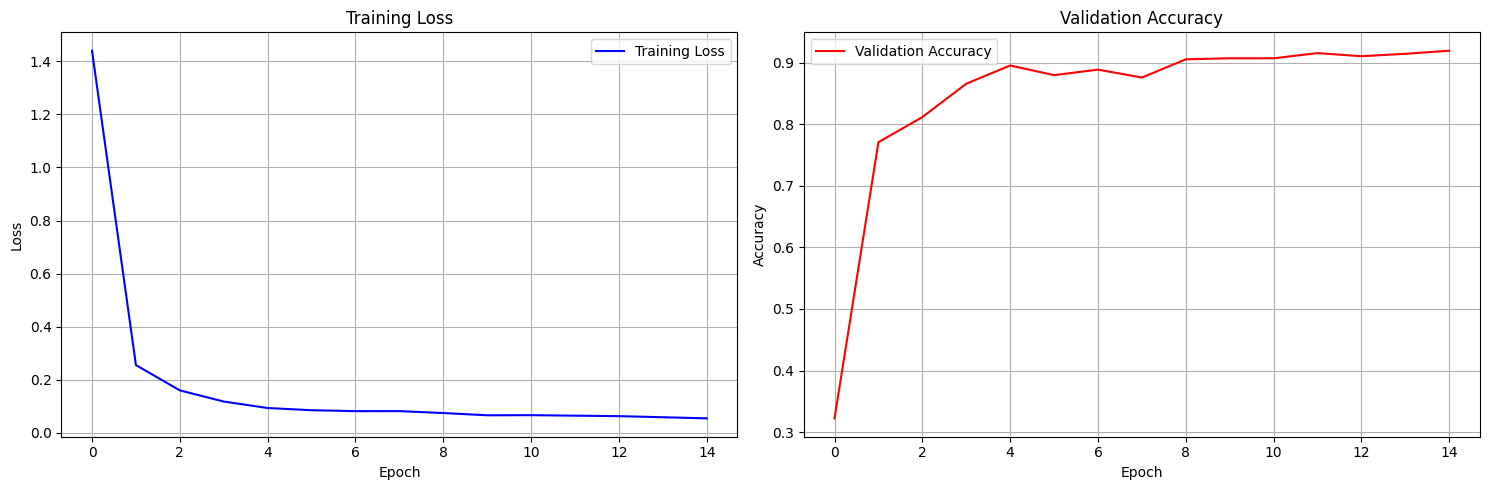


Inference Speed Test:
Average time per batch (32 images): 0.0042 seconds
Average time per image: 0.0001 seconds
Estimated FPS: 7690.19


In [ ]:
# Performance visualization
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(train_losses, 'b-', label='Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot validation accuracy
    ax2.plot(val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot if we have training data
if 'train_losses' in locals() and 'val_accuracies' in locals():
    plot_training_curves(train_losses, val_accuracies)
else:
    print("No training data available for plotting")

# Model inference time test
import time

def test_inference_speed(model, test_loader, num_batches=10):
    model.eval()
    times = []

    with torch.no_grad():
        for batch_idx, (images, labels, label_lengths) in enumerate(test_loader):
            if batch_idx >= num_batches:
                break

            images = images.to(device)

            # Time the forward pass
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            batch_time = end_time - start_time
            times.append(batch_time)

    avg_time = sum(times) / len(times)
    avg_per_image = avg_time / images.size(0)

    print(f"\nInference Speed Test:")
    print(f"Average time per batch ({images.size(0)} images): {avg_time:.4f} seconds")
    print(f"Average time per image: {avg_per_image:.4f} seconds")
    print(f"Estimated FPS: {1/avg_per_image:.2f}")

# Test inference speed if test_loader exists
if 'test_loader' in locals():
    test_inference_speed(model, test_loader)
else:
    print("No test loader available for speed test")

So yolo inference time was roughly 10ms per image on average, plus the average 1ms of pdlpr inference = about 11ms for the complete pipeline.
So about 110 FPS

# ONLINE COMPLETE PIPELINE

In [ ]:
class LicensePlateRecognitionPipeline:
    def __init__(self, yolo_model_path, pdlpr_model_path, device='cuda'):
        """
        Pipeline completa per detection e riconoscimento targhe

        Args:
            yolo_model_path: Path al modello YOLOv5 addestrato
            pdlpr_model_path: Path al modello PDLPR addestrato
            device: Device da usare ('cuda' o 'cpu')
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Carica modello YOLOv5
        self.yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=yolo_model_path)
        self.yolo_model.to(self.device)
        self.yolo_model.eval()

        # Carica modello PDLPR
        self.pdlpr_model = PDLPR(num_classes=BLANK_IDX + 1, dropout=0.1).to(self.device)
        checkpoint = torch.load(pdlpr_model_path, map_location=self.device)
        self.pdlpr_model.load_state_dict(checkpoint['model_state_dict'])
        self.pdlpr_model.eval()

        # Transform per PDLPR
        self.transform = transforms.Compose([
            transforms.Resize((64, 256)),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        print("Pipeline initialized successfully!")

    def yolo_crop(self, image_path):
        """
        detecting plates

        Args:
            image_path

        Returns:
            cropped image
        """
        img = Image.open(image_path)
        ris = self.yolo_model(image_path)  # Usa self.yolo_model
        metadata = ris.pred[0]

        # Prendi solo la prima detection (o la migliore)
        if len(metadata) > 0:
            det = metadata[0]  # Prima detection
            x1, y1, x2, y2 = map(int, det[:4])
            cropped = img.crop((x1, y1, x2, y2))
            return cropped
        else:
            print("Nessuna targa rilevata!")
            return None

    def recognize_plate(self, plate_crop):
        """
        Riconosce il testo di una targa usando PDLPR

        Args:
            plate_crop: Crop della targa (PIL Image)

        Returns:
            Testo riconosciuto
        """
        if plate_crop is None:
            return ""

        plate_crop_tr = self.transform(plate_crop).unsqueeze(0)
        plate_crop_tr = plate_crop_tr.to(self.device)

        with torch.no_grad():
            outputs = self.pdlpr_model(plate_crop_tr)  # Usa self.pdlpr_model
            pred_string = ctc_greedy_decoder(outputs, idx2char)

        return pred_string[0] if pred_string else ""

    def __call__(self, img_path):
        """
        Rende l'oggetto callable - metodo principale della pipeline

        Args:
            img_path: Path all'immagine

        Returns:
            Testo della targa riconosciuto
        """
        crop = self.yolo_crop(img_path)
        plate = self.recognize_plate(crop)
        return plate


In [ ]:
online_model = LicensePlateRecognitionPipeline(yolo_model_path = "/content/yolo_finetuned_model.pt", pdlpr_model_path = "/content/best_pdlpr_model.pth", device = "cuda")

Using device: cuda


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-18 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Pipeline initialized successfully!


In [ ]:
plate = online_model("/content/ccpd_green/test/0026484674329501916-93_90-283&513_362&543-360&543_283&539_283&513_362&518-0_0_3_25_32_32_33_33-93-14.jpg")



In [ ]:
get_plate("0026484674329501916-93_90-283&513_362&543-360&543_283&539_283&513_362&518-0_0_3_25_32_32_33_33-93-14.jpg")

'皖AD18899'

In [ ]:
plate

'皖AD18899'